#   Plot co-visibilty time of a source at two or more telescopes

In [1]:
from astropy.time import Time
from astroplan import download_IERS_A 
import pandas as pd

from astropy.coordinates import EarthLocation
from astroplan import Observer,FixedTarget
import astroplan
from astroplan.plots import plot_airmass,plot_altitude
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import common_timezones
import pyorbital

pd.set_option("display.max_rows", None, "display.max_columns", None)

%matplotlib inline

In [2]:
hydraA=FixedTarget.from_name("Hydra_A")   
#selecting target  - Hydra_A
Ra,Dec=hydraA.ra,hydraA.dec                 #Extracting RA and Dec  since not manually imputed 
print(hydraA,Ra, Dec)                                #Checking if correct values were loaded
HydraA_skycoord = SkyCoord('139d31m24.765s', '-12d05m43.99s', frame='icrs')

<FixedTarget "Hydra_A" at SkyCoord (ICRS): (ra, dec) in deg (139.52354583, -12.09555278)> 139d31m24.765s -12d05m43.99s


In [3]:
ctio = Observer.at_site("ctio", timezone = 'America/Santiago')


location_spt = EarthLocation.from_geodetic(90.0*u.deg,0.0*u.deg,2800*u.m)
spt= Observer(location=location_spt, name="South Pole Telescope", timezone='Pacific/Auckland')


print(spt)
kmtnet= Observer.at_site("Siding Spring Observatory", name='KMTNET',timezone = 'Australia/Sydney')

<Observer: name='South Pole Telescope',
    location (lon, lat, el)=(90.0 deg, 0.0 deg, 2800.000000000187 m),
    timezone=<DstTzInfo 'Pacific/Auckland' LMT+11:39:00 STD>>


In [4]:
start_obs = Time('2020-11-24 04:00:00')
end_obs= Time('2020-11-24 19:27:00')
delta_t = end_obs - start_obs
dt = start_obs + delta_t*np.linspace(0, 1,75)
dt_datetime = [x.datetime for x in dt]

In [5]:
#dt

In [6]:
#Airmasses at ctio

airmass_ctio=ctio.altaz(dt, hydraA).secz

masked_airmass_ctio = np.ma.array(airmass_ctio, mask=airmass_ctio < 1)

#Airmasses at kmtnet
airmass_kmtnet=kmtnet.altaz(dt,hydraA).secz
masked_airmass_kmtnet = np.ma.array(airmass_kmtnet, mask=airmass_kmtnet < 1)


#Airmasses at SPT
airmass_spt=spt.altaz(dt, hydraA).secz

masked_airmass_spt = np.ma.array(airmass_spt, mask=airmass_spt < 1)

In [7]:
#Finding the intersecting point

ndx = np.argwhere(np.diff(np.sign(masked_airmass_ctio - masked_airmass_kmtnet))).flatten()
ndx=ndx[0]
intersect=dt_datetime[ndx]
intersect

datetime.datetime(2020, 11, 24, 14, 26, 21, 81081)

In [8]:
d={'datetimes':dt_datetime,'ctio-airmass':masked_airmass_ctio,'kmtnet-airmass':masked_airmass_kmtnet}
df=pd.DataFrame(data=d)  #Creating a dataframe  

df=df.round(3) # Rounding up values 
df.dropna() # Dropping NaN values but maintaining indexes in case there are NANs
#df

,datetimes,ctio-airmass,kmtnet-airmass
42,2020-11-24 12:46:08.108108,1.419,30.148
43,2020-11-24 12:58:39.729730,1.490,12.681
44,2020-11-24 13:11:11.351351,1.572,8.023
45,2020-11-24 13:23:42.972973,1.669,5.869
46,2020-11-24 13:36:14.594595,1.783,4.631
47,2020-11-24 13:48:46.216216,1.919,3.829
48,2020-11-24 14:01:17.837838,2.083,3.268
49,2020-11-24 14:13:49.459459,2.283,2.856
50,2020-11-24 14:26:21.081081,2.531,2.541
51,2020-11-24 14:38:52.702703,2.848,2.292


In [9]:

##Getting the start of intersect

ind=np.where(df['kmtnet-airmass']<3)
index2=ind[0][0] #Indices of first occurance
covis_start=df['datetimes'][index2]
covis_start

Timestamp('2020-11-24 14:13:49.459459')

In [10]:

#Another method of getting the intersecting point 
df['diff']=df['ctio-airmass']-df['kmtnet-airmass']
idx=np.max(np.where((abs(round(df['diff'],1)==0.0))))

mid_time=df['datetimes'][idx]
mid_time

Timestamp('2020-11-24 14:26:21.081081')

In [11]:
#airmass_spt

from astropy.coordinates import get_moon
#Generate moon positions 
moon_radec=[]
for i in dt:
    get_moon(i)
    moon_radec.append(get_moon(i))

    
#convert them to radec format   
radecs=[]
for i in moon_radec:
    c = SkyCoord(ra=i.ra, dec=i.dec)
    radecs.append(c.to_string('hmsdms'))
    
#Splitting them
radec2=[]
for e in radecs:
    radec2.append(e.split(' '))
    
    
#Conveting to degrees
moon_locs=[]
l=np.arange(0,len(radec2))
for i in (l):
    moon_locs.append(SkyCoord(radec2[i][0],radec2[i][1], frame='icrs'))

#Get seperations in degrees
sep=[]
for i in moon_locs:
    sep.append(HydraA_skycoord.separation(i).deg)
#making them numpy arrays
sep=np.array(sep)   

In [18]:
sunset_CT = ctio.sun_set_time(start_obs, which='nearest')
sunrise_CT = ctio.sun_rise_time(start_obs, which='nearest')

moonset_ctio = ctio.moon_set_time(start_obs, which='nearest')
moonrise_ctio = ctio.moon_rise_time(start_obs, which='next')
moonrise_ctio,moonset_ctio=moonrise_ctio.iso,moonset_ctio.iso


twilight_morning_ctio=ctio.twilight_morning_astronomical(start_obs, which='nearest')
twilight_evening_ctio=ctio.twilight_evening_astronomical(start_obs, which='nearest')
twilight_morning_ctio,twilight_evening_ctio=twilight_morning_ctio.iso,twilight_evening_ctio.iso

#KMTNET
sunset_kmtnet = kmtnet.sun_set_time(start_obs, which='nearest')
sunrise_kmtnet = kmtnet.sun_rise_time(start_obs, which='next')
sunset_kmtnet,sunrise_kmtnet=sunset_kmtnet.iso,sunrise_kmtnet.iso


moonset_kmtnet = kmtnet.moon_set_time(start_obs, which='nearest')
moonrise_kmtnet = kmtnet.moon_rise_time(start_obs, which='next')
moonrise_kmtnet,moonset_kmtnet=moonrise_kmtnet.iso,moonset_kmtnet.iso


twilight_morning_kmtnet=kmtnet.twilight_morning_astronomical(start_obs, which='nearest')
twilight_evening_kmtnet=kmtnet.twilight_evening_astronomical(start_obs, which='nearest')
twilight_morning_kmtnet,twilight_evening_kmtnet=twilight_morning_kmtnet.iso,twilight_evening_kmtnet.iso

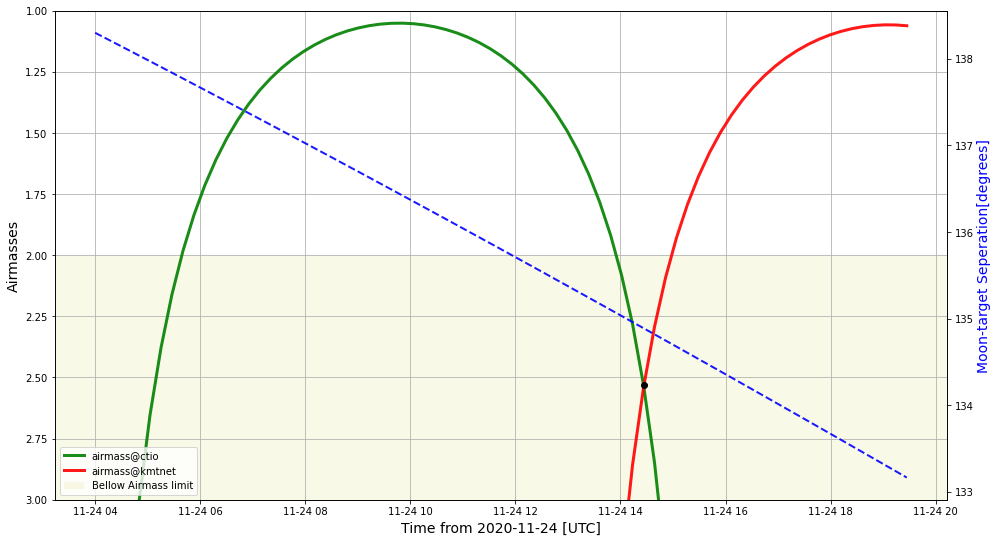

In [24]:
#Plotting


fig, ax = plt.subplots(figsize=(16,9))
ax.plot(dt_datetime, masked_airmass_ctio, label='airmass@ctio',color='g',linewidth=3, alpha=0.9)
ax.plot(dt_datetime, masked_airmass_kmtnet, color='r', label='airmass@kmtnet',linewidth=3, alpha=0.9)
ax.invert_yaxis()
ax.set_ylim([3,1])
ax.set_ylabel('Airmasses', color='k',fontsize=14)
ax.set_xlabel("Time from {0} [UTC]".format(min(dt_datetime).date()),fontsize=14)









ax2 = ax.twinx()
ax.axhspan(3, 2, facecolor='y', alpha=0.09,label='Bellow Airmass limit')
ax2.plot(dt_datetime, sep, color='b',linestyle='--', label='moon_sep',linewidth=2, alpha=0.9)
ax.legend(loc='lower left',prop={'size': 10})
ax2.set_ylabel('Moon-target Seperation[degrees]',color='b',fontsize=14)
ax.grid()






#plotting intersect
ax.plot(dt_datetime[ndx], masked_airmass_ctio[ndx], 'ko')


In [13]:
#Calculating co visibilities
date_1=covis_start

date_2=intersect

# returns a timedelta object 
delta = date_2-date_1
print('Difference: ', delta) 
  
mins = delta.total_seconds() / 60
print('Total difference in minutes: ',str(mins) + ' '+'mins') 

print('Total time co-observable in minutes: ',str(mins*2) + ' '+'mins')


Difference:  0 days 00:12:31.621622
Total difference in minutes:  12.527027033333333 mins
Total time co-observable in minutes:  25.054054066666666 mins


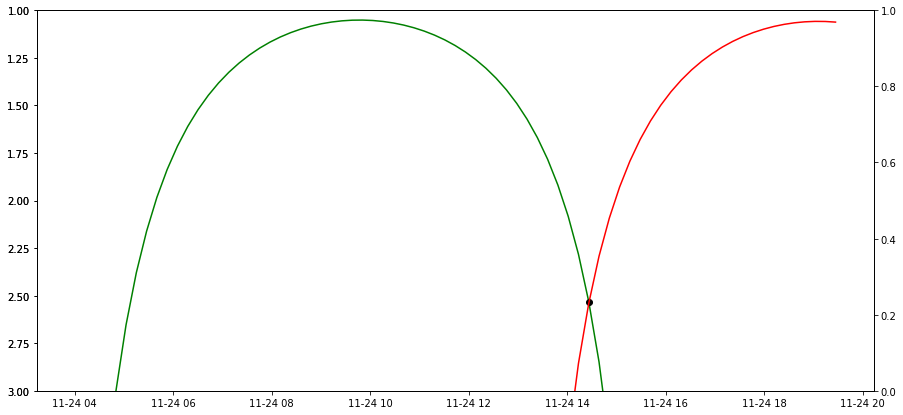

In [15]:
#Plotting 
fig, ax = plt.subplots(figsize=(15,7))
ax.invert_yaxis()
ax.set_ylim([3,1])
ax2 = ax.twinx()
ax.plot(dt_datetime, masked_airmass_ctio, '-',label='airmass@ctio', color='g')
ax2.plot(dt_datetime, masked_airmass_kmtnet, '-',color='r')
ax2.set_ylim([3,1])
ax3=ax2.twinx()


#plotting intersect
ax.plot(dt_datetime[ndx], masked_airmass_ctio[ndx], 'ko')


In [25]:
dec_range= np.linspace(-90,91,360)

RA_range=np.arange(1,361,1)
#RA_range


In [26]:
len(RA_range)

360

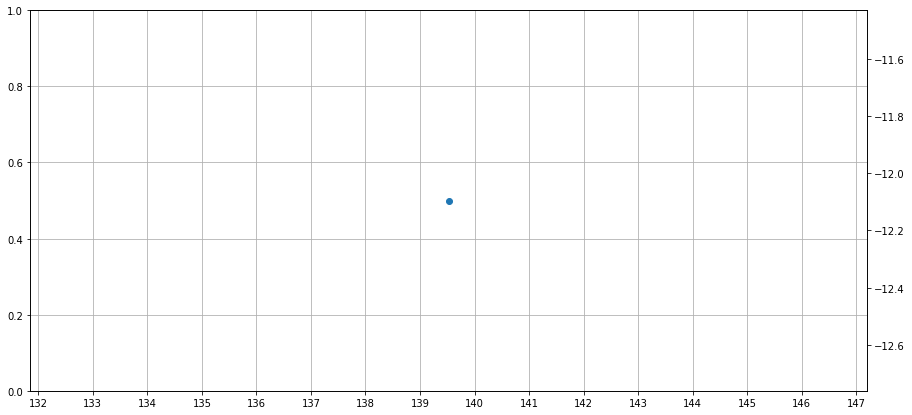

In [30]:
fig, ax = plt.subplots(figsize=(15,7))

ax2 = ax.twinx()

#ax.set_yticks(dec_range)
ax.set_xticks(RA_range)

ax2.scatter(139.52354583,-12.09555278)

ax.grid()

#Getting the start of the  doesnt work wih

from itertools import takewhile

def f(l, b): return len([x for x in takewhile(lambda x: x[1] >b, enumerate(l))])

index=f(masked_airmass_kmtnet, 3.0)
covis_start=(dt.datetime[index])
covis_start